# Query database

In [1]:
# Import the relevant packages
import psycopg2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.time import Time
from astropy.io import ascii, fits
from collections import OrderedDict

from penquins import Kowalski
from bson.json_util import loads, dumps
import gzip
import io
from matplotlib.colors import LogNorm
from astropy.stats import sigma_clipped_stats, mad_std

### Connect to the psql database

In [2]:
# Read the secrets
info = ascii.read('./db_access.csv', format='csv')
info_db = info[info['db'] == 'db_kn_rt_user']
db_kn = f"host={info_db['host'][0]} dbname={info_db['dbname'][0]} \
port={info_db['port'][0]} user={info_db['user'][0]} \
password={info_db['password'][0]}"

# Connect
con = psycopg2.connect(db_kn)
cur = con.cursor()
print(f"Connected to the '{info_db['dbname'][0]}' database")

Connected to the 'database_kn_rt' database


## Tables
There are multiple tables in the database. Here you can print the names of the tables and the names of the columns available in each table

In [3]:
# Table names
tables = pd.read_sql_query("SELECT table_name FROM information_schema.tables WHERE table_schema='public' ",con)

for t in tables["table_name"]:
    print(f"Table {t}:")
    q = pd.read_sql_query(f"SELECT column_name FROM INFORMATION_SCHEMA.COLUMNS WHERE TABLE_NAME = '{t}'", con)
    print(q)

Table crossmatch:
                column_name
0                        id
1                      name
2                    clu_id
3                    clu_ra
4                   clu_dec
5                     clu_z
6                  clu_zerr
7               clu_distmpc
8                 clu_mstar
9               clu_sfr_fuv
10               clu_sfr_ha
11               clu_w1mpro
12            clu_w1sigmpro
13               clu_w2mpro
14            clu_w2sigmpro
15               clu_w3mpro
16            clu_w3sigmpro
17               clu_w4mpro
18            clu_w4sigmpro
19             clu_type_ned
20                    clu_a
21                  clu_b2a
22             clu_dist_kpc
23           clu_sep_arcsec
24         glade_sep_arcsec
25          glade_name_gwgc
26          glade_name_sdss
27            glade_name_hl
28         glade_name_2mass
29                 glade_ra
30                glade_dec
31                  glade_z
32           glade_dist_mpc
33       glade_dist_mpc_err
34

### Plotting functions

In [4]:
def make_triplet(alert, normalize: bool = False):
    """
        Feed in alert packet
    """
    cutout_dict = dict()

    for cutout in ('science', 'template', 'difference'):
        cutout_data = loads(dumps([alert[f'cutout{cutout.capitalize()}']['stampData']]))[0]

        # unzip
        with gzip.open(io.BytesIO(cutout_data), 'rb') as f:
            with fits.open(io.BytesIO(f.read())) as hdu:
                data = hdu[0].data
                # replace nans with zeros
                cutout_dict[cutout] = np.nan_to_num(data)
                # normalize
                if normalize:
                    cutout_dict[cutout] /= np.linalg.norm(cutout_dict[cutout])

        # pad to 63x63 if smaller
        shape = cutout_dict[cutout].shape
        if shape != (63, 63):
            cutout_dict[cutout] = np.pad(cutout_dict[cutout], [(0, 63 - shape[0]), (0, 63 - shape[1])],
                                         mode='constant', constant_values=1e-9)

    triplet = np.zeros((63, 63, 3))
    triplet[:, :, 0] = cutout_dict['science']
    triplet[:, :, 1] = cutout_dict['template']
    triplet[:, :, 2] = cutout_dict['difference']

    return triplet

def plot_triplet(tr):
    fig = plt.figure(figsize=(8, 2), dpi=120)
    ax1 = fig.add_subplot(131)
    ax1.axis('off')
    mean, median, std = sigma_clipped_stats(tr[:, :, 0])
    ax1.imshow(tr[:, :, 0], vmin = median - 2*std, vmax = median + 3*std)
    #ax1.imshow(tr[:, :, 0], origin='upper', cmap=plt.cm.bone, norm=LogNorm())
    ax1.title.set_text('Science')
    ax2 = fig.add_subplot(132)
    ax2.axis('off')
    mean, median, std = sigma_clipped_stats(tr[:, :, 1])
    ax2.imshow(tr[:, :, 1], vmin = median - 2*std, vmax = median + 3*std)
    #ax2.imshow(tr[:, :, 1], origin='upper', cmap=plt.cm.bone, norm=LogNorm())
    ax2.title.set_text('Reference')
    ax3 = fig.add_subplot(133)
    ax3.axis('off')
    mean, median, std = sigma_clipped_stats(tr[:, :, 2])
    ax3.imshow(tr[:, :, 2], vmin = median - 2*std, vmax = median + 3*std)
    #ax3.imshow(tr[:, :, 2], origin='upper', cmap=plt.cm.bone)
    ax3.title.set_text('Difference')
    plt.show()

def get_cutouts(name, username, password):
    """Query kowalski to get the candidate stamps"""
    
    k = Kowalski(username=username, password=password, verbose=False)

    if type(name) == str:
        list_names = [name]
    elif type(name) == list:
        list_names = name
    else:
        print(f"{name} must be a list or a string")
        return None

    q = {"query_type": "find",
         "query": {
                   "catalog": "ZTF_alerts",
                   "filter": {
                              'objectId': {'$in': list(list_names)}
                              },
                   "projection": {
                                  "objectId": 1,
                                  "candidate.jd": 1,
                                  "candidate.ra": 1,
                                  "candidate.dec": 1,
                                  "candidate.magpsf": 1,
                                  "candidate.fid": 1,
                                  "candidate.sigmapsf": 1,
                                  "candidate.programid": 1,
                                  "candidate.field": 1,
                                  "candidate.rcid": 1,
                                  "cutoutScience": 1,
                                  "cutoutTemplate": 1,
                                  "cutoutDifference": 1,
                                  }
                       },
         "kwargs": {"hint": "objectId_1"}
         }

    r = k.query(query=q)

    if r['result_data']['query_result'] == []:
        print("No candidates to be checked?")
        return None
    else:
        alerts = r['result_data']['query_result']

    return alerts

    """
        name = info["objectId"]
        cutouts[name] = {'science': r['result_data']['query_result'][0]["cutoutScience"],
               'template': r['result_data']['query_result'][0]["cutoutTemplate"],
               'difference': r['result_data']['query_result'][0]["cutoutDifference"]}
    return cutouts
    """

# Read the secrets
secrets = ascii.read('secrets.csv', format='csv')
username_kowalski = secrets['kowalski_user'][0]
password_kowalski = secrets['kowalski_pwd'][0]

## Scoring

Assign or remove 'points' based on soft constraints

In [5]:
# Start with full list, hard rejects will be removed HERE
scoring_df = pd.read_sql_query("SELECT name FROM candidate where hard_reject is NULL", con)

# Define the thresholds
thresh = {'rise': {'g': -1.0, 'r': -1., 'i': -0.5, 'sign_select': '<', 'sign_reject': '>'},
          'fade': {'g': 0.58, 'r': 0.43, 'i': 0.30, 'sign_select': '>', 'sign_reject': '<'}
          }

# Define the filters (list)
list_filters = ['g', 'r', 'i']

# Rise, fade, or both? (list, e.g. ['rise', 'fade'])
list_rise_fade = ['rise', 'fade']

scores = {'rise_select': 5,
          'rise_pen': 0,
          'fade_select': 10,
          'fade_pen': -100,
         }

print(f"Working with {len(scoring_df)} candidates")
print(f"Considering the following filter(s): {list_filters}")
print("---")
print("Selected thresholds:")
for k1 in thresh.keys():
    for k2 in thresh[k1].keys():
        print(f"{k1} {k2}: {thresh[k1][k2]}")
print("---")
print("Scoring points:")
for k in scores.keys():
    print(f"{k}: {scores[k]}")

Working with 1058 candidates
Considering the following filter(s): ['g', 'r', 'i']
---
Selected thresholds:
rise g: -1.0
rise r: -1.0
rise i: -0.5
rise sign_select: <
rise sign_reject: >
fade g: 0.58
fade r: 0.43
fade i: 0.3
fade sign_select: >
fade sign_reject: <
---
Scoring points:
rise_select: 5
rise_pen: 0
fade_select: 10
fade_pen: -100


### Filter rise and fade (alerts)

In [6]:
# Filter for rise and fade for ALERTS
for rf in list_rise_fade:
    for f in list_filters:
        rf_filt = pd.read_sql_query(f"SELECT name FROM candidate WHERE index_{rf}_{f} {thresh[rf]['sign_select']} {thresh[rf][f]}",con).values
        print(f"{rf}_{f}_filt_alerts: {len(rf_filt)}" )

        # Assign points if condition is met, otherwise 0
        scoring_df[f'{rf}_{f}_filt_alerts'] = [scores[f"{rf}_select"] if name in rf_filt else 0 for name in scoring_df['name']]

rise_g_filt_alerts: 0
rise_r_filt_alerts: 0
rise_i_filt_alerts: 0
fade_g_filt_alerts: 1
fade_r_filt_alerts: 1
fade_i_filt_alerts: 0


### Filter rise and fade (forced phot)

In [7]:
# Filter for rise and fade for FORCED PHOTOMETRY
for rf in list_rise_fade:
    for f in list_filters:
        rf_filt = pd.read_sql_query(f"SELECT name FROM candidate WHERE index_{rf}_forced_{f} {thresh[rf]['sign_select']} {thresh[rf][f]}",con).values
        print(f"{rf}_{f}_filt_forced: {len(rf_filt)}" )

        # Assign points if condition is met, otherwise 0
        scoring_df[f'{rf}_{f}_filt_forced'] = [scores[f"{rf}_select"] if name in rf_filt else 0 for name in scoring_df['name']]

rise_g_filt_forced: 1
rise_r_filt_forced: 0
rise_i_filt_forced: 0
fade_g_filt_forced: 1
fade_r_filt_forced: 3
fade_i_filt_forced: 5


### Filter rise and fade (forced phot, STACK)

In [8]:
# Filter for rise and fade for STACKED FORCED PHOTOMETRY
for rf in list_rise_fade:
    for f in list_filters:
        rf_filt = pd.read_sql_query(f"SELECT name FROM candidate WHERE index_{rf}_stack_{f} {thresh[rf]['sign_select']} {thresh[rf][f]}",con).values
        print(f"{rf}_{f}_filt_stack: {len(rf_filt)}" )

        # Assign points if condition is met, otherwise 0
        scoring_df[f'{rf}_{f}_filt_stack'] = [scores[f"{rf}_select"] if name in rf_filt else 0 for name in scoring_df['name']]

rise_g_filt_stack: 0
rise_r_filt_stack: 0
rise_i_filt_stack: 0
fade_g_filt_stack: 2
fade_r_filt_stack: 1
fade_i_filt_stack: 1


### Penalize slow rise or fade (alerts)

In [9]:
# Penalize slow rise and fade for ALERTS
for rf in list_rise_fade:
    for f in list_filters:
        rf_filt = pd.read_sql_query(f"SELECT name FROM candidate WHERE index_{rf}_{f} {thresh[rf]['sign_reject']} {thresh[rf][f]}",con).values
        print(f"{rf}_{f}_pen_alerts: {len(rf_filt)}" )

        # Assign points if condition is met, otherwise 0
        scoring_df[f'{rf}_{f}_pen_alerts'] = [scores[f"{rf}_pen"] if name in rf_filt else 0 for name in scoring_df['name']]

rise_g_pen_alerts: 134
rise_r_pen_alerts: 268
rise_i_pen_alerts: 29
fade_g_pen_alerts: 75
fade_r_pen_alerts: 154
fade_i_pen_alerts: 19


### Penalize slow fade (forced phot)

In [10]:
# Penalize slow rise and fade for FORCED PHOTOMETRY
for rf in list_rise_fade:
    for f in list_filters:
        rf_filt = pd.read_sql_query(f"SELECT name FROM candidate WHERE index_{rf}_forced_{f} {thresh[rf]['sign_reject']} {thresh[rf][f]}",con).values
        print(f"{rf}_{f}_pen_forced: {len(rf_filt)}" )

        # Assign points if condition is met, otherwise 0
        scoring_df[f'{rf}_{f}_pen_forced'] = [scores[f"{rf}_pen"] if name in rf_filt else 0 for name in scoring_df['name']]

rise_g_pen_forced: 88
rise_r_pen_forced: 125
rise_i_pen_forced: 28
fade_g_pen_forced: 54
fade_r_pen_forced: 52
fade_i_pen_forced: 16


### Penalize slow fade (forced phot, STACK)

In [11]:
# Penalize slow rise and fade for FORCED PHOTOMETRY
for rf in list_rise_fade:
    for f in list_filters:
        rf_filt = pd.read_sql_query(f"SELECT name FROM candidate WHERE index_{rf}_stack_{f} {thresh[rf]['sign_reject']} {thresh[rf][f]}",con).values
        print(f"{rf}_{f}_pen_stack: {len(rf_filt)}" )

        # Assign points if condition is met, otherwise 0
        scoring_df[f'{rf}_{f}_pen_stack'] = [scores[f"{rf}_pen"] if name in rf_filt else 0 for name in scoring_df['name']]

rise_g_pen_stack: 58
rise_r_pen_stack: 71
rise_i_pen_stack: 16
fade_g_pen_stack: 21
fade_r_pen_stack: 25
fade_i_pen_stack: 13


## Penalize candidates with long duration in forced photometry

In [12]:
# Penalize long duration transients - TOTAL
duration_pen = pd.read_sql_query("SELECT name FROM candidate \
WHERE duration_tot > 14", con).drop_duplicates('name').values
print('duration_pen: ' + str(len(duration_pen)))

scoring_df['duration_pen'] = [-100 if name in duration_pen else 0 for name in scoring_df['name']]

# Penalize long duration transients - INDIVIDUAL FILTERS
duration_dict = {"g": 10, "r": 12, "i": 14}
for f in ["g", "r", "i"]:
    duration_pen = pd.read_sql_query(f"SELECT name FROM candidate \
    WHERE duration_{f} > {duration_dict[f]}", con).drop_duplicates('name').values
    print(f'duration_pen_{f}: ' + str(len(duration_pen)))
    scoring_df[f'duration_pen_{f}'] = [-100 if name in duration_pen else 0 for name in scoring_df['name']]

duration_pen: 1
duration_pen_g: 48
duration_pen_r: 1
duration_pen_i: 0


##  Crossmatch scoring
Have ranges in assigning/penalizing points based on rising rate -> fast +1, slow-1, between 0. Ranges defined by RCF SN results, and/or 2018cow

Points for candidates with more than 6 detections

Point there is a non-PSF LS source with phot_z less than x

Penalize if PS object within 1.5 arcsec

Point is PS source with sgscore less than x and mag brighter than y

### Present in either CLU or GLADE 
NOTE: GLADE crossmatch is not yet implemented, WIP.

In [13]:
# Filter for match in either CLU or GLADE 
galaxy_match_filt = pd.read_sql_query("SELECT name FROM crossmatch \
WHERE (clu_dist_kpc < 100) and (clu_distmpc > 10)", con).drop_duplicates('name').values
print('galaxy_match_filt: ' + str(len(galaxy_match_filt)))


# Now the CLU crossmatching is giving zero points, change as desired. 
scoring_df['galaxy_match_filt'] = [1 if name in galaxy_match_filt else 0 for name in scoring_df['name']]

galaxy_match_filt: 237


# Results

In [14]:
scoring_df.head()

,name,rise_g_filt_alerts,rise_r_filt_alerts,rise_i_filt_alerts,fade_g_filt_alerts,fade_r_filt_alerts,fade_i_filt_alerts,rise_g_filt_forced,rise_r_filt_forced,rise_i_filt_forced,...,rise_r_pen_stack,rise_i_pen_stack,fade_g_pen_stack,fade_r_pen_stack,fade_i_pen_stack,duration_pen,duration_pen_g,duration_pen_r,duration_pen_i,galaxy_match_filt
0,ZTF20aaschoy,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ZTF20abqprqh,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ZTF20abqppiv,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ZTF20abqypri,0,0,0,0,0,0,0,0,0,...,0,0,-100,0,0,0,0,0,0,1
4,ZTF20abqnctf,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
# Create dataframe with the results
result_df = pd.DataFrame([])
result_df['name'] = scoring_df['name']
result_df['sum'] = scoring_df.sum(axis=1)
result_df.sort_values(by='sum', ascending=False)[:12]

,name,sum
815,ZTF20aauonhf,60
14,ZTF20abqizgp,21
303,ZTF20aauocqd,11
413,ZTF20aashzyv,10
248,ZTF20aawccar,1
350,ZTF20aawlxph,1
253,ZTF20aaweqle,1
107,ZTF20aaxajyf,1
252,ZTF20aawejbm,1
251,ZTF20aawcrze,1


### Distribution of the resultng scores

In [16]:
# Define a scoring threshold
score_thresh = 1

There are 4 candidates above the scoring threshold


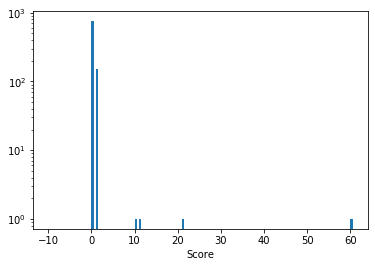

In [17]:
fig, ax = plt.subplots(1,1)
print(f"There are {len(result_df[result_df['sum'] > score_thresh])} candidates above the scoring threshold")

bins = 'auto'
#bins = np.arange(np.min(result_df['sum']), np.max(result_df['sum']), 0.5)
bins = np.arange(-10, np.max(result_df['sum'])+1, 0.5)

ax.hist(result_df['sum'], bins=bins)
ax.set_yscale('log')
ax.set_xlabel("Score")
#plt.savefig("score_distribution.png")
plt.show()

# Plot the results

### More plotting functions to compile
Note 1: There is a lot of stuff not quite necessary, we can remove it later<br>
Note 2: I started to add commands to perform an automatic extinction correction, not active yet

In [18]:
def get_dust_info(coords):
    """
    Get coordinates as a SkyCoord object
    and returns E(B-V) 
    """
    from dustmaps.planck import PlanckQuery
    from dustmaps.sfd import SFDQuery
    
    planck = PlanckQuery()
    ebv = planck(coords)
    #print('E(B-V) = {:.3f} mag'.format(ebv))

    return ebv


def plot_lc(name, forced=True, stack=False, plot_alerts=True, save=False, reddening=False,
            plot_cow=True, plot_gfo=True, plot_bulla=True, filtermatch = 'g',
            plot_gw=False, inset=False, tr=None, writecsv=False):
    '''Plot the light curve of a candidate'''

    color_dict = {'g': 'green', 'r': 'red', 'i': 'y'}
    forced_dict = {'1': 's', '0': 'o'}

    if forced is False:
        plot_alerts = True
        lc = pd.DataFrame(columns=['jd', 'mag', 'mag_unc', 'filter', 'limmag', 'forced'])
    else:
        if stack is True:
            table = 'lightcurve_stacked'        
        elif forced is True:
            table = 'lightcurve_forced'
        lc = pd.read_sql_query(f"SELECT jd, mag, mag_unc, filter, limmag FROM {table} \
WHERE name = '{name}'", con)
        lc["forced"] = np.ones(len(lc))

    if plot_alerts is True:
        alerts = pd.read_sql_query(f"SELECT jd, magpsf, sigmapsf, filter FROM lightcurve \
WHERE name = '{name}'", con)
        # Remove the alerts if they are way too many
        if len(alerts) > 80:
            print("TOO MANY ALERTS!!!! Not plotting them")
        for i, a in alerts.iterrows():
            if len(alerts) > 80:
                continue
            # If the time difference between the alert and any forced phot is >5min, consider the alert
            if lc.empty or np.min(np.abs(np.array(lc['jd']) - np.array(a['jd']))) > 5./60/60/24.:
                #print(f"Adding an alert for {name}")
                new_row = [a['jd'], a['magpsf'], a['sigmapsf'], a["filter"], 99.0, 0]
                new_row = pd.DataFrame([new_row], columns=['jd', 'mag', 'mag_unc', 'filter', 'limmag', 'forced'])
                lc = lc.append([lc, new_row], ignore_index=True)

    # Plot    
    if plot_gw is True:
        gw_info = {'ZTF19acbqtue': {'gw_name': 'S190930t',
                                    'gw_time': Time('2019-09-30 14:34:07', format='iso')}                  
                  }
        if name in gw_info.keys():
            t0 = gw_info[name]['gw_time'].jd
            xlabel = gw_info[name]['gw_name']
        else:
            t0 = np.min(lc['jd'].values)
            xlabel = Time(t0, format='jd').iso[0:1]
    else:
        if lc.empty:
            print(f"Empty light curve for {name} with forced={forced}, stack={stack}, plot_alerts={plot_alerts}")
            return
        t0 = np.min(lc[lc['mag'] < 50]['jd'].values)
        xlabel = Time(t0, format='jd').iso[0:19]

    # Correct for Galactic extinction
    if reddening is True:
        # Get the coordinates
        coords_tbl = pd.read_sql_query(f"SELECT ra, dec FROM candidate \
                                WHERE name = '{name}'", con)
        coords = SkyCoord(ra=coords_tbl["ra"][0].value*u.deg, dec=coords_tbl["dec"][0].value*u.deg)
        ebv = get_dust_info(coords)
        
        """
        # Dict with correction factor to go from ebv to A_lambda
        corr_dict = ["g": 3.3, "r", "i"]
        """
    
    fig, ax1 = plt.subplots(1, 1, figsize=(9,6))
    
    for f in set(lc['filter']):
        tf = lc[lc['filter'] == f]

        """
        # Correct for the extinction
        if reddening is True:
            corr = ebv * corr_dict[f]
            tf["mag"] = tf["mag"] - 
            tf["limmag"] = tf["limmag"] - 
        """
        tf_det = tf[tf['mag'] < 50.]
        tf_ul = tf[tf['mag'] > 50.]
        for isforced in [0,1]:
            if isforced == 0:
                label = f"{f} alerts"
            else:
                if stack is True:
                    label = f"{f} forced phot stacked"
                else:
                    label = f"{f} forced phot"
            tf_det2 = tf_det[tf_det['forced'] == isforced]
            if len(tf_det2) == 0:
                continue
            ax1.errorbar(tf_det2['jd'].values - t0, tf_det2['mag'], yerr=tf_det2['mag_unc'],
                         color=color_dict[f], markeredgecolor='k',
                         fmt=forced_dict[str(int(isforced))], label=label)
        if len(tf_ul) != 0:
            ax1.errorbar(tf_ul['jd'].values - t0, tf_ul['limmag'], markeredgecolor=color_dict[f],
                         markerfacecolor='w', fmt='v')
            plt.plot([],[], 'kv', markeredgecolor='k', markerfacecolor='w', label='upper limits')
  

    # Determine the row at which the filter we want to match (filtermatch), peaks
    if plot_cow or plot_gfo:
        peak_row = lc.iloc[lc[lc['mag'] < 50.][lc['filter'] == filtermatch]['mag'].idxmin()]
    
    # Overplot 2018cow in the filters for which there is candidate photometry (limits)
    if plot_cow:
        AT2018cow = pd.read_fwf('../comparison_photometry/AT2018cow_photometry_table.dat',sep = ' ', comment = '#', header = None,\
            names = ['mjd', 'telescope', 'filter', 'mag', 'ABmag', 'magerr', 'source'])
        peak_row_cow = AT2018cow.iloc[AT2018cow[AT2018cow["filter"] == peak_row['filter']]['mag'].idxmin()]
        peak_offset = peak_row['mag'] - peak_row_cow['mag']
        mjd_offset = t0 - peak_row['jd'] + peak_row_cow['mjd']
        for f in set(lc['filter']):
            cow_filt = AT2018cow[AT2018cow['filter'] == f]
            ax1.plot(cow_filt['mjd'] - mjd_offset, cow_filt['ABmag'] + peak_offset,
                         color=color_dict[f], linestyle = ':')
            plt.plot([],[], color = 'black', linestyle = ':', label='AT 2018cow')

    # Overplot 2017gfo in the filters for which there is candidate photometry (limits)
    if plot_gfo:
        AT2017gfo = pd.read_csv('../comparison_photometry/AT2017gfo_optical_photometry_smartt+17.txt',sep = ' ', comment = '#',na_values='-')
        peak_row_gfo = AT2017gfo.iloc[[AT2017gfo[peak_row['filter']].idxmin()]]
        peak_offset = peak_row['mag'] - peak_row_gfo[peak_row['filter']]
        mjd_offset = t0 - peak_row['jd'] + peak_row_gfo['Phase']
        for f in set(lc['filter']):
            nanmask = np.isfinite(AT2017gfo[f])
            ax1.plot(AT2017gfo['Phase'][nanmask] - mjd_offset.values, AT2017gfo[f][nanmask] + peak_offset.values,\
                     color=color_dict[f], linestyle = '-')
            plt.plot([],[], color = 'black', linestyle = '-', label='AT 2017gfo')
    
    # Overplot decline rates in g and r from Bulla models    
    if plot_bulla:
        peak_r = lc.iloc[lc.query("mag < 50. & filter == 'r'")['mag'].idxmin()]
        peak_g = lc.iloc[lc.query("mag < 50. & filter == 'g'")['mag'].idxmin()]
        x = np.arange(0,7,0.01)
        ax1.plot(x + peak_r['jd'] - t0, x * 0.3 + peak_r['mag'], linestyle = '--', color = 'red', alpha=0.5)
        ax1.plot(x + peak_g['jd'] - t0, x * 0.5 + peak_g['mag'], linestyle = '--', color = 'green', alpha=0.5)
        plt.plot([],[], color = 'black', linestyle = '--', label='Bulla upper limits')

    plt.gca().invert_yaxis()

    #ax1.set_title(name)
    ax1.set_xlabel(f"Days from {xlabel}", fontsize=18)
    ax1.set_ylabel("Magnitude (AB)", fontsize=18)
    
    # Legend
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), fontsize=16)


    ax1.tick_params(axis='both',       # changes apply to the x-axis
                    which='both',      # both major and minor ticks are affected
                    labelsize=16)

    # Add the discovery image as inset
    if inset is True:
        # Define the position
        # Reference
        cm = plt.cm.cubehelix
        left, bottom, width, height = [0.51, 0.6, 0.23, 0.23]
        ax2 = fig.add_axes([left, bottom, width, height])
        ax2.axis('off')
        #mean, median, std = sigma_clipped_stats(tr[:, :, 1])
        #ax2.imshow(tr[:, :, 0], vmin = median - 0.*std, vmax = median + 4*std)

        # From Tomas 
        s_max, s_min = [1.001,1.001], [1.001,1.001]
        img_data = tr[:, :, 0]
        imgd_scaled = np.log10(img_data)
        vmax = np.sort(imgd_scaled[28:36,28:36].flatten())[-3]
        npixel = (len(img_data)+1)**2
        imgd_flat = img_data.flatten()
        imgd_scaled[imgd_scaled<0]=np.nanmedian(img_data)
        v_onesig = np.log10(np.nanmedian(img_data) - mad_std(imgd_flat[np.isnan(imgd_flat)==False])*1.4826)
        vmin= max(v_onesig, np.nanmin(imgd_scaled))
        ax2.imshow(imgd_scaled, cmap=cm, vmax=s_max[0]*vmax, vmin=vmin*s_min[0])
        
        '''
        # Subtraction
        left, bottom, width, height = [0.68, 0.6, 0.23, 0.23]
        ax3 = fig.add_axes([left, bottom, width, height])
        ax3.axis('off')
        mean, median, std = sigma_clipped_stats(tr[:, :, 2])
        ax3.imshow(tr[:, :, 2], vmin = median - 2*std, vmax = median + 3*std)
        '''
        
        # Reference
        left, bottom, width, height = [0.68, 0.6, 0.23, 0.23]
        ax3 = fig.add_axes([left, bottom, width, height])
        ax3.axis('off')
        s_max, s_min = [1.001,1.001], [1.001,1.001]
        img_data = tr[:, :, 1]
        imgd_scaled = np.log10(img_data)
        vmax = np.sort(imgd_scaled[28:36,28:36].flatten())[-3]
        npixel = (len(img_data)+1)**2
        imgd_flat = img_data.flatten()
        imgd_scaled[imgd_scaled<0]=np.nanmedian(img_data)
        v_onesig = np.log10(np.nanmedian(img_data) - mad_std(imgd_flat[np.isnan(imgd_flat)==False])*1.4826)
        vmin= max(v_onesig, np.nanmin(imgd_scaled))
        ax3.imshow(imgd_scaled, cmap=cm, vmax=s_max[0]*vmax, vmin=vmin*s_min[0])
        
        
        # Add candidate name
        ax2.text(0.8, 0.57, name, color='k', fontsize=16, ha='center', va='center', transform=ax1.transAxes)
    

    #ax1.set_xlim([0,14])
    #ax1.set_ylim([22,18])
    
    if save is True or writecsv is True:
        if forced is True:
            forcedbool = 1
        else:
            forcedbool = 0
        if stack is True:
            stackbool = 1
        else:
            stackbool = 0
        plt.savefig(f"lc_{name}_forced{forcedbool}_stacked{stackbool}.png")
        if writecsv is True:
            lc.to_csv(f"lightcurves/lc_{name}_forced{forcedbool}_stacked{stackbool}.csv")
    plt.show()

In [19]:
def get_xmatch_clu_glade(list_names):
    # Filter for match in either CLU or GLADE 
    str_names = "'" + "', '".join(list_names) + "'"

    galaxy_match_clu = pd.read_sql_query(f"SELECT name, \
    clu_ra, clu_dec, clu_distmpc, clu_z, clu_dist_kpc, clu_sep_arcsec \
    FROM crossmatch \
    WHERE name in ({str_names}) and clu_ra is not NULL", con)

    galaxy_match_glade = pd.read_sql_query(f"SELECT name, \
    glade_ra, glade_dec, glade_dist_mpc, glade_z, glade_dist_kpc, glade_sep_arcsec \
    FROM crossmatch \
    WHERE name in ({str_names}) and glade_ra is not NULL", con)

    return galaxy_match_clu, galaxy_match_glade

### Plot up
Define the list of candidates to plot. By default, it plots all those with score larger than the `score_thresh` previously defined

/Users/igor/Software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


ZTF20aauonhf
No CLU crossmatch


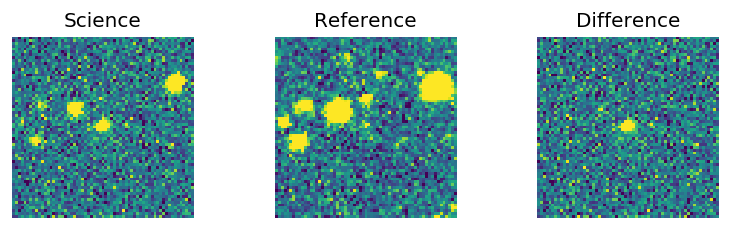

Alerts light curve for ZTF20aauonhf


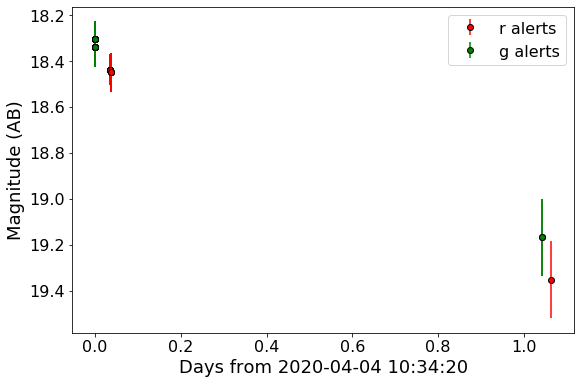

Forced photometry light curve for ZTF20aauonhf


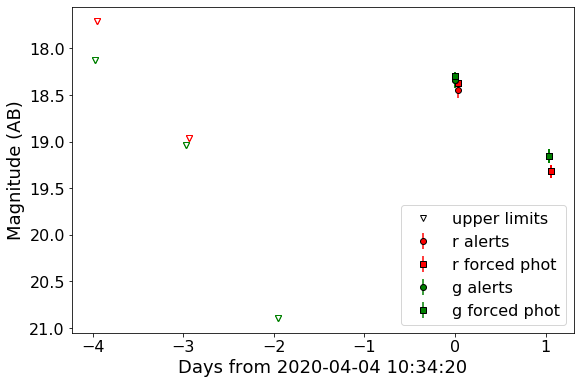

Stacked forced photometry light curve for ZTF20aauonhf


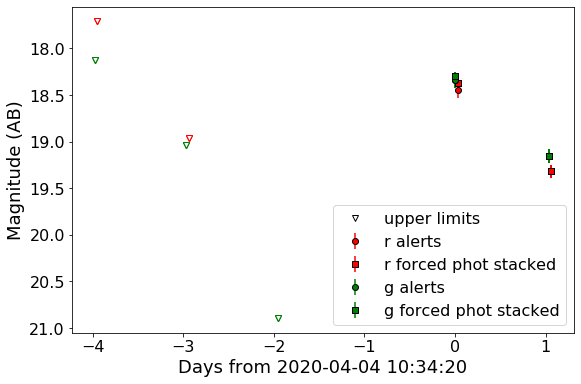

------
ZTF20abqizgp
CLU crossmatch:
           name     clu_ra    clu_dec  clu_distmpc     clu_z  clu_dist_kpc  \
1  ZTF20abqizgp  231.07425  30.175139    129.78009  0.031168     86.364075   

   clu_sep_arcsec  
1      137.261938  


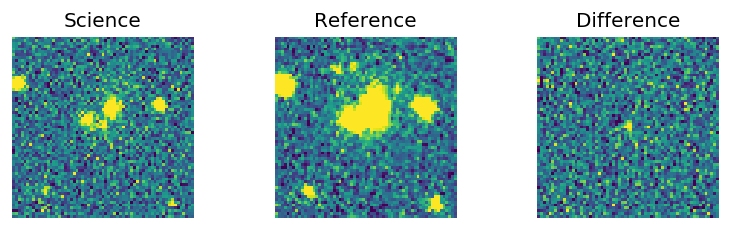

Alerts light curve for ZTF20abqizgp


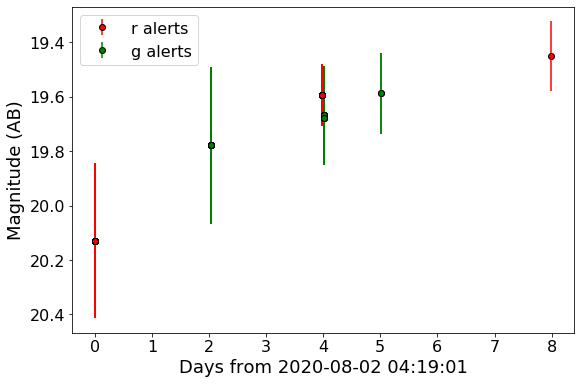

Forced photometry light curve for ZTF20abqizgp


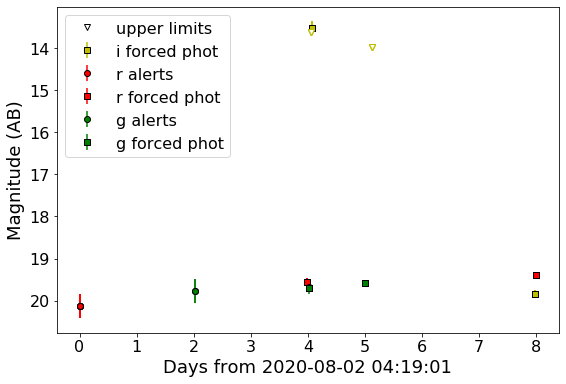

Stacked forced photometry light curve for ZTF20abqizgp


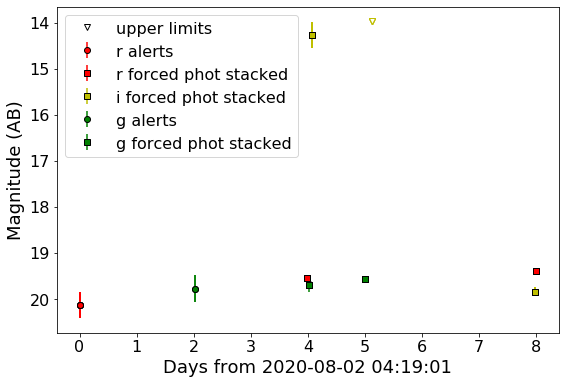

------
ZTF20aauocqd
CLU crossmatch:
           name      clu_ra   clu_dec  clu_distmpc     clu_z  clu_dist_kpc  \
0  ZTF20aauocqd  226.759797  61.22808   186.966934  0.044902     93.666963   

   clu_sep_arcsec  
0       103.33483  


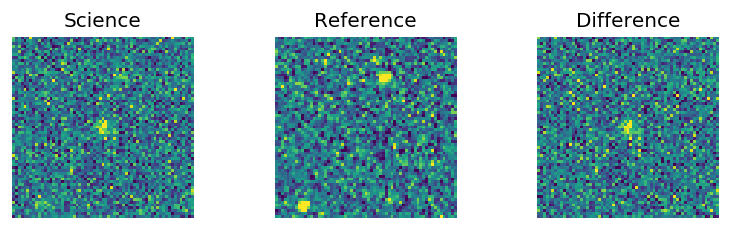

Alerts light curve for ZTF20aauocqd


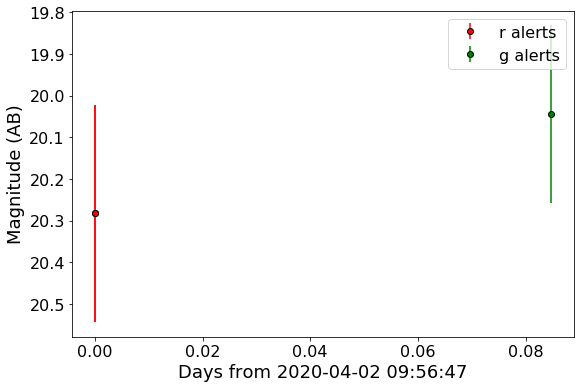

Forced photometry light curve for ZTF20aauocqd


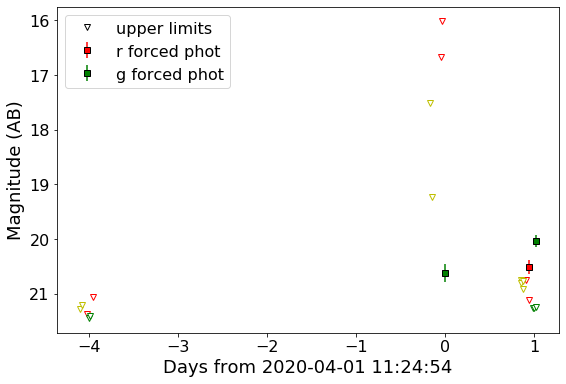

Stacked forced photometry light curve for ZTF20aauocqd


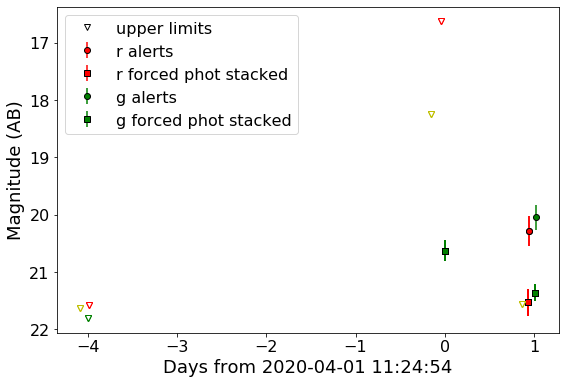

------
ZTF20aashzyv
No CLU crossmatch


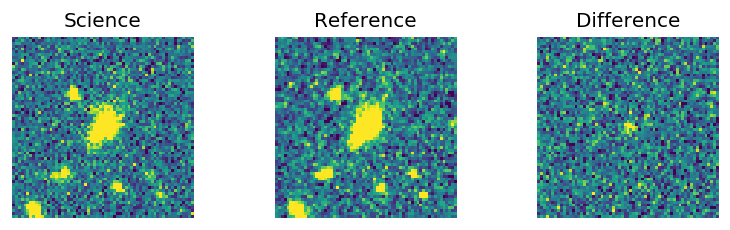

Alerts light curve for ZTF20aashzyv


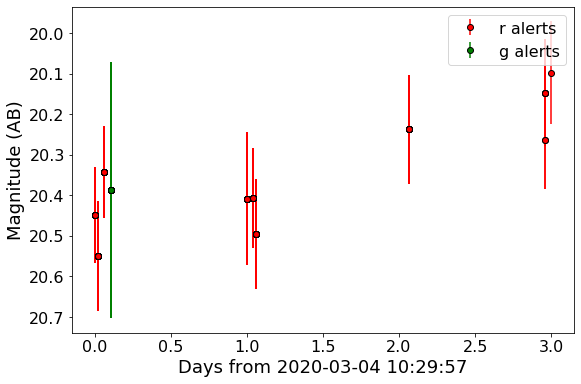

Forced photometry light curve for ZTF20aashzyv


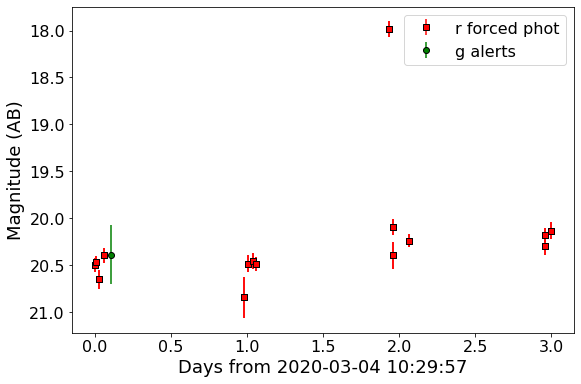

Stacked forced photometry light curve for ZTF20aashzyv


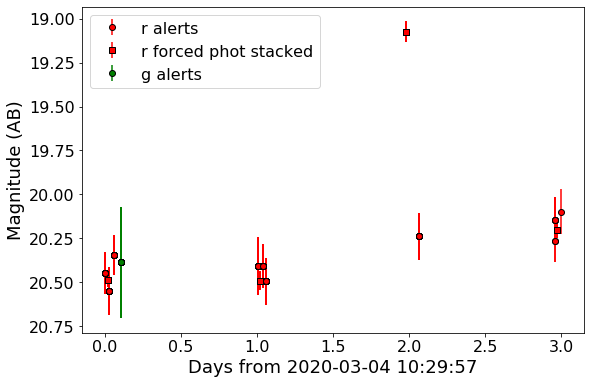

------
Found 4 candidates
['ZTF20aauonhf', 'ZTF20abqizgp', 'ZTF20aauocqd', 'ZTF20aashzyv']


In [20]:
list_names = result_df.sort_values(by='sum', ascending=False)[result_df['sum'] > score_thresh]['name']

# Get CLU and GLADE crossmatch information
clu, glade = get_xmatch_clu_glade(list_names)
list_out = []

for name in list_names:
    print(name)
    clu_crossmatch = clu[clu['name'] == name]
    if clu_crossmatch.empty:
        print("No CLU crossmatch")
    else:
        print("CLU crossmatch:")
        print(clu[clu['name'] == name])
    ###print(glade[glade['name'] == name])
    alerts = get_cutouts(name, username_kowalski, password_kowalski)
    triplet = make_triplet(alerts[0])
    plot_triplet(triplet)
    print(f"Alerts light curve for {name}")
    plot_lc(name, forced=False, stack=False, plot_alerts=True, save=False, inset=False, tr=triplet, plot_cow=False, plot_gfo=False, plot_bulla=False, filtermatch='g')    
    print(f"Forced photometry light curve for {name}")
    plot_lc(name, forced=True, stack=False, plot_alerts=True, save=False, inset=False, tr=triplet, plot_cow=False, plot_gfo=False, plot_bulla=False, filtermatch='g')
    print(f"Stacked forced photometry light curve for {name}")
    plot_lc(name, forced=True, stack=True, plot_alerts=True, save=False, inset=False, tr=triplet, plot_cow=False, plot_gfo=False, plot_bulla=False, filtermatch='g')
    print("------")
    list_out.append(name)
print(f"Found {len(list_out)} candidates")
print(list_out)

# The End
What you actually need for the scanning finishes here.

# Bonus commands

### Generate a list for kowalski query
This are simply helpful commands that output a list of candidates already in the right format (mongodb) for checking them out on [Kowalski Lab](https://kowalski.caltech.edu/lab/ztf-alerts) 

In [31]:
# Generate list for kowalski
list_names = result_df['name'][result_df['sum']> score_thresh].values
# list_names = [name for name in list_names]
list_names = str(list_names)
kow = "{'objectId': {'$in': " + list_names.replace(' ', ', ') + "}}"
print(kow)

{'objectId': {'$in': ['ZTF20abqizgp', 'ZTF20aauocqd', 'ZTF20aashzyv', 'ZTF20aauonhf']}}


## Plot stacking photometry for paper

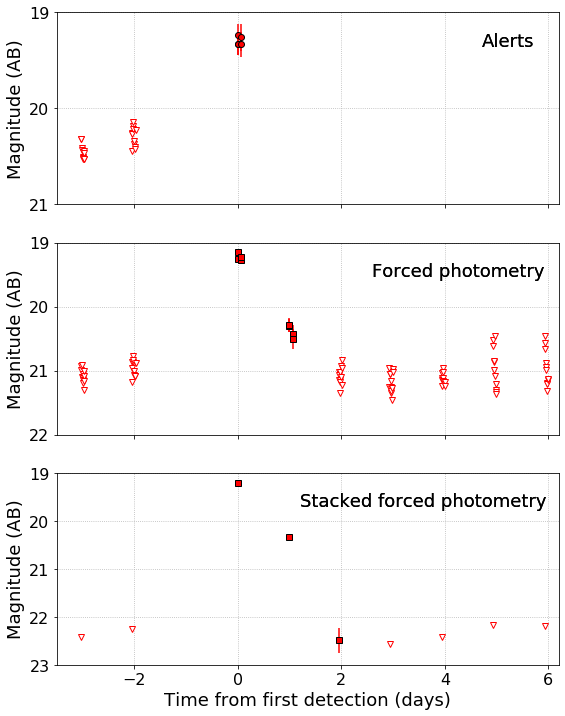

In [5]:
from matplotlib.ticker import MaxNLocator

def get_lc_example(name, forced=True, stack=False, plot_alerts=True, save=False,
                   tr=None, writecsv=False):
    '''Get the light curve of a candidate'''

    if forced is False:
        plot_alerts = True
        lc = pd.DataFrame(columns=['jd', 'mag', 'mag_unc', 'filter', 'limmag', 'forced'])
    else:
        if stack is True:
            table = 'lightcurve_stacked'        
        elif forced is True:
            table = 'lightcurve_forced'
        lc = pd.read_sql_query(f"SELECT jd, mag, mag_unc, filter, limmag FROM {table} \
WHERE name = '{name}'", con)
        lc["forced"] = np.ones(len(lc))

    if plot_alerts is True:
        alerts = pd.read_sql_query(f"SELECT jd, magpsf, sigmapsf, filter FROM lightcurve \
WHERE name = '{name}'", con)
        # FIXME REMOVE!!!!!!!!
        if len(alerts) > 20:
            print("TOO MANY ALERTS!!!! Not plotting them")
        for i, a in alerts.iterrows():
            # FIXME REMOVE!!!!!!!!!!!
            if len(alerts) > 20:
                continue
            # If the time difference between the alert and any forced phot is >5min, consider the alert
            if lc.empty or np.min(np.abs(np.array(lc['jd']) - np.array(a['jd']))) > 5./60/60/24.:
                #print(f"Adding an alert for {name}")
                new_row = [a['jd'], a['magpsf'], a['sigmapsf'], a["filter"], 99.0, 0]
                new_row = pd.DataFrame([new_row], columns=['jd', 'mag', 'mag_unc', 'filter', 'limmag', 'forced'])
                lc = lc.append([lc, new_row], ignore_index=True)

    return lc

###############

name = "ZTF19abcpiag"

# Initialize the figure
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(9,12), sharex=True)

for ax, doforced, stack, ylim, phot, pos in zip([ax1, ax2, ax3], [False, True, True],
                                     [False, False, True],
                                    [[21,19], [22,19], [23,19]],
                                    ["Alerts", "Forced photometry", "Stacked forced photometry"],
                                    [0.9, 0.8, 0.73]):

    save = False
    writecsv = False
    
    color_dict = {'g': 'green', 'r': 'red', 'i': 'y'}
    forced_dict = {'1': 's', '0': 'o'}
    
    # Get the light curve
    if phot == "Alerts":
        lc = pd.read_csv("lc_ZTF19abcpiag_alerts.csv")
        lc = lc.rename(columns={"magpsf": "mag", "sigmamagpsf": "mag_unc", "jdobs": "jd"})
        lc["forced"] = np.zeros(len(lc))

    else:
        lc = get_lc_example(name, forced=doforced, stack=stack, plot_alerts=False, save=False, tr=None, writecsv=False )

    # Starting time
    t0 = np.min(lc[lc['mag'] < 50]['jd'].values)
    xlabel = Time(t0, format='jd').iso[0:19]
    
    for f in set(lc['filter']):
        tf = lc[lc['filter'] == f]
        tf_det = tf[tf['mag'] < 50.]
        tf_ul = tf[tf['mag'] > 50.]
        for isforced in [0,1]:
            if isforced == 0:
                label = f"{f} alerts"
            else:
                if stack is True:
                    label = f"{f} forced phot stacked"
                else:
                    label = f"{f} forced phot"
            tf_det2 = tf_det[tf_det['forced'] == isforced]
            if len(tf_det2) == 0:
                continue
            ax.errorbar(tf_det2['jd'].values - t0, tf_det2['mag'], yerr=tf_det2['mag_unc'],
                         color=color_dict[f], markeredgecolor='k',
                         fmt=forced_dict[str(int(isforced))], label=label)
        if len(tf_ul) != 0:
            ax.errorbar(tf_ul['jd'].values - t0, tf_ul['limmag'], markeredgecolor=color_dict[f],
                         markerfacecolor='w', fmt='v')
            plt.plot([],[], 'kv', markeredgecolor='k', markerfacecolor='w', label='upper limits')
        ax.tick_params(axis='both',       # changes apply to the x-axis
                        which='both',      # both major and minor ticks are affected
                        labelsize=16)
        ax.set_ylabel("Magnitude (AB)", fontsize=18)
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        #ax.legend(by_label.values(), by_label.keys(), fontsize=16, loc='lower right')
        
        # Add name
        ax.text(pos, 0.85, phot, color='k', fontsize=18, ha='center', va='center', transform=ax.transAxes)

        ax.set_ylim(ylim)
        ax.grid(linestyle='dotted')
    
    
    if save is True or writecsv is True:
        if forced is True:
            forcedbool = 1
        else:
            forcedbool = 0
        if stack is True:
            stackbool = 1
        else:
            stackbool = 0
        plt.savefig(f"lc_{name}_forced{forcedbool}_stacked{stackbool}.png")
        if writecsv is True:
            lc.to_csv(f"../lc_paper/lc_{name}_forced{forcedbool}_stacked{stackbool}.csv")

#ax1.set_title(name)
#ax.set_xlabel(f"Days from {xlabel}", fontsize=18)
ax.set_xlabel(f"Time from first detection (days)", fontsize=18)
ax.set_xlim([-3.5, 6.2])

#plt.gca().invert_yaxis()
    
# Legend
#handles, labels = plt.gca().get_legend_handles_labels()
#by_label = OrderedDict(zip(labels, handles))

plt.savefig(f"lc_example_stacked_{name}.pdf")

plt.show()


## Close the database connection

In [ ]:
cur.close()
con.close()